In [1]:
import torch
import numpy as np
from torch import nn
from time import time
from capsules import *
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

In [3]:
class CapsNet4MNIST(nn.Module):
    
    def __init__(self):
        super(CapsNet4MNIST, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=256,
                kernel_size=9,
                stride=1
            ),
            nn.ReLU(inplace=True)
        )
        self.primcaps = PrimaryCapsuleLayer()
        self.digicaps = SecondaryCapsuleLayer()
        self.decoder = RegularizingDecoder()
        
    def forward(self, x):
        """Compute forward of capsules, get the longest vectors, reconstruct the pictures"""
        internal = self.digicaps(self.primcaps(self.conv(x)))
        lengths = find_probability(internal)
        _, max_caps_index = lengths.max(dim=-1)
        max_caps = torch.stack(
            [get_a_capsule(internal, a, b) for a,b in enumerate(max_caps_index)]
        )
        reconstruction = self.decoder(max_caps)
        return(internal, reconstruction, max_caps_index)

In [5]:
cn = CapsNet4MNIST().cuda()
optimizer = Adam(cn.parameters())
capsule_loss = CapsuleLoss().cuda()

In [6]:
%%bash
git clone https://github.com/sorki/python-mnist.git
cd python-mnist/
./get_data.sh

data directory already present, exiting


fatal: destination path 'python-mnist' already exists and is not an empty directory.


In [7]:
from mnist import MNIST
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
test_img, test_lab = mndata.load_testing()

In [8]:
images = np.array(images)
labels = np.array(labels)
test_img = np.array(test_img)
test_lab = np.array(test_lab)

In [9]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [10]:
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []
start_time = time()
n_epochs = 10
for epoch in range(10):
    print("Epoch #"+str(epoch))
    cn.train()
    running_loss = []
    running_accuracy = []
    i = 0
    epoch_time = time()
    for batch_X, batch_y in iterate_minibatches(images, labels, 100):
        if i % 100 == 0:
            print("Minibatch "+str(i)+" of "+str(round(images.shape[0]/100)))
        i += 1
        optimizer.zero_grad()
        inp = Variable(
            torch.from_numpy(batch_X.reshape(batch_X.shape[0],1,28,28)/255.0).type(torch.FloatTensor)
        ).cuda()
        real_class = Variable(
            torch.from_numpy(batch_y).type(torch.LongTensor)
        ).cuda()
        internal, reconstruction, classes = cn(inp)
        loss = capsule_loss(internal, inp.view(inp.size(0), 28*28), real_class, reconstruction)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().data.numpy())
        running_accuracy.append(
            accuracy_score(classes.cpu().data.numpy(), batch_y)
        )
    training_loss.append(np.mean(running_loss))
    training_accuracy.append(np.mean(running_accuracy))
    print("Training loss: "+str(training_loss[-1]))
    print("Training accuracy: "+str(training_accuracy[-1]))
    print("Training in "+str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
    cn.eval()
    running_test_loss = []
    running_test_accuracy = []
    i = 0
    for batch_X, batch_y in iterate_minibatches(test_img, test_lab, 100):
        if i % 100 == 0:
            print("Testing minibatch "+str(i)+" of "+str(round(test_img.shape[0]/100)))
        i += 1
        test_X = Variable(
            torch.from_numpy(batch_X.reshape(batch_X.shape[0],1,28,28)/255.0).type(torch.FloatTensor)
        ).cuda()
        test_Y = Variable(
            torch.from_numpy(batch_y).type(torch.LongTensor)
        ).cuda()
        test_internal, test_reconstruction, test_classes = cn(test_X)
        running_test_loss.append(
            capsule_loss(
                test_internal, test_X.reshape(test_X.size(0), 28*28), 
                test_Y, test_reconstruction
            ).cpu().data.numpy()
        )
        running_test_accuracy.append(
            accuracy_score(test_classes.cpu().data.numpy(), batch_y)
        )
    testing_loss.append(np.mean(running_test_loss))
    testing_accuracy.append(np.mean(running_test_accuracy))
    print("Testing loss: "+str(testing_loss[-1]))
    print("Testing accuracy: "+str(testing_accuracy[-1]))
    print(str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
print("All epochs took "+str((time() - start_time)/60) + " minutes")

Epoch #0
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 0.7771286
Training accuracy: 0.3481
Training in 0th epoch took 7.381724643707275 minutes
Testing minibatch 0 of 100
Testing loss: 0.69051737
Testing accuracy: 0.49029999999999996
0th epoch took 7.763855520884196 minutes
Epoch #1
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 0.53729045
Training accuracy: 0.6430166666666667
Training in 1th epoch took 7.298186536629995 minutes
Testing minibatch 0 of 100
Testing loss: 0.2895898
Testing accuracy: 0.8201999999999999
1th epoch took 7.689721500873565 minutes
Epoch #2
Minibatch 0 of 600
Minibatch 100 of 600
Minibatch 200 of 600
Minibatch 300 of 600
Minibatch 400 of 600
Minibatch 500 of 600
Training loss: 0.13487282
Training accuracy: 0.9493500000000002
Training in 2th epoch took 7.323831303914388 minutes
Tes

Text(0.5,1,'Accuracy')

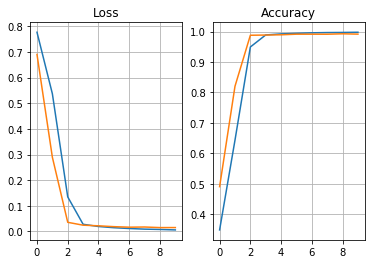

In [21]:
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.plot(testing_loss)
plt.grid(True)
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.grid(True)
plt.title("Accuracy")

In [22]:
torch.save(cn.state_dict(), "mnist_capsule.ptch")

In [39]:
cn.eval()
random_sample = test_img[np.random.choice(range(test_img.shape[0]), 2)]

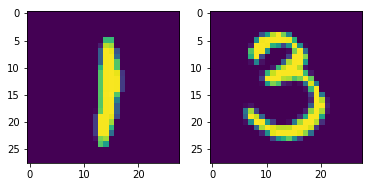

In [40]:
plt.subplot(1,2,1)
plt.imshow(random_sample[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(random_sample[1].reshape(28,28))

In [41]:
_,rec,cl = cn(Variable(torch.from_numpy(random_sample.reshape(2,1,28,28)/255).type(torch.FloatTensor)).cuda())

In [42]:
cl

tensor([ 1,  3], device='cuda:0')

In [43]:
rec = rec.cpu().data.numpy()

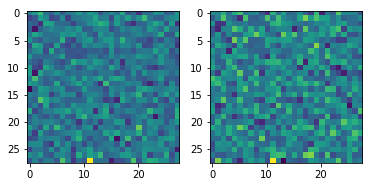

In [44]:
plt.subplot(1,2,1)
plt.imshow(rec[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(rec[1].reshape(28,28))